# 0.0. IMPORTS

In [179]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import datetime
import matplotlib.gridspec as gridspec

from scipy import stats
from IPython.display import Image
from matplotlib import pyplot as plt

## 0.1. Helper Functions

In [164]:
def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr - 1)))

def jupyter_settings():
    %matplotlib inline
   
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    # display( HTML( '<style>.container { width:100% !important; }</style>') )
    # pd.options.display.max_columns = None
    # pd.options.display.max_rows = None
    # pd.set_option( 'display.expand_frame_repr', False )
    # sns.set()

In [165]:
jupyter_settings()

## 0.2. Loading Data

In [2]:
df_sales_raw = pd.read_csv('C:/Users/rodri/Desktop/repos/data_science_em_producao/notebooks/datasets/train.csv', low_memory = False)
df_store_raw = pd.read_csv('C:/Users/rodri/Desktop/repos/data_science_em_producao/notebooks/datasets/store.csv', low_memory = False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

In [3]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
639790,566,4,2013-12-05,5704,579,1,1,0,0,a,a,3620.0,NaN,NaN,1,40.0,2013.0,"Jan,Apr,Jul,Oct"


# 1.0. DESCRIÇÃO DOS DADOS

In [4]:
df1 = df_raw.copy()

df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list( map(snakecase,cols_old))

#rename
df1.columns = cols_new

## 1.2 Data Dimension 

In [6]:
print('Number of Rows {}' .format(df1.shape[0]))
print('Number of Cols {}' .format(df1.shape[1]))

Number of Rows 1017209
Number of Cols 18


## 1.3 Data Types

In [7]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA (not available) NAN(not a number)

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [9]:
df1['competition_distance'].max()

75860.0

In [10]:
# competition_distance: vou substituir por uma valor muito maior que o máximo que tinha
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)
#na funcao apply, quando usa mais de duas colunas deve-se usar axis =1 para indicar que deve ser feito ao longo das colunas

# competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
                           
# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

# promo_interval
month_map = {1: 'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5: 'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec' }

df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)


df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)
df1

#3 formas: exclui os NA, usa algoritma Machine leanning para ver comportamento e preencher (media, mediana ou clusterizacao) ou pensar no negócio pq gerou esse NA

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",Jan,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,1.0,2013.0,0,Jan,0
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,1.0,2013.0,0,1.0,2013.0,0,Jan,0
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,1.0,2013.0,0,1.0,2013.0,0,Jan,0


In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64'])

### 1.7.1 Numerical Attributes

In [16]:
# Central Tendency
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']


In [17]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [18]:
num_attributes.agg(['mean','median','std','min','max','skew','kurtosis']).T.reset_index().rename(columns={'index': 'attributes'}) 
#Outra forma de fazer

,attributes,mean,median,std,min,max,skew,kurtosis
0,store,558.429727,558.0,321.908651,1.0,1115.0,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.997391,1.0,7.0,0.001593,-1.246873
2,sales,5773.818972,5744.0,3849.926175,0.0,41551.0,0.641460,1.778375
3,customers,633.145946,609.0,464.411734,0.0,7388.0,1.598650,7.091773
4,open,0.830107,1.0,0.375539,0.0,1.0,-1.758045,1.090723
5,promo,0.381515,0.0,0.485759,0.0,1.0,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,12547.652996,20.0,200000.0,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,3.311087,1.0,12.0,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,5.515593,1900.0,2015.0,-7.235657,124.071304


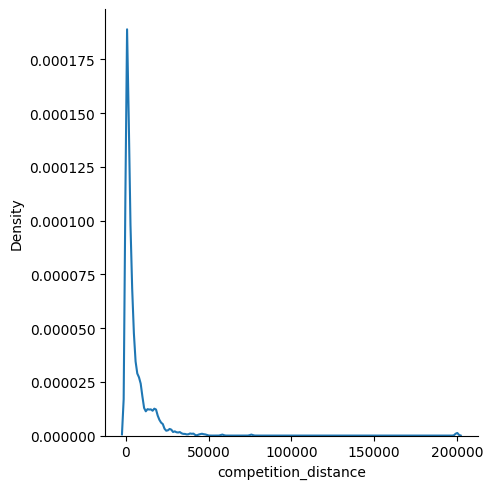

In [19]:
sns.displot(df1['competition_distance'], kind = 'kde')

### 1.7.2 Categorical Attributes

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

date              942
state_holiday       4
store_type          4
assortment          3
promo_interval      4
month_map          12
dtype: int64

<Axes: xlabel='state_holiday', ylabel='sales'>

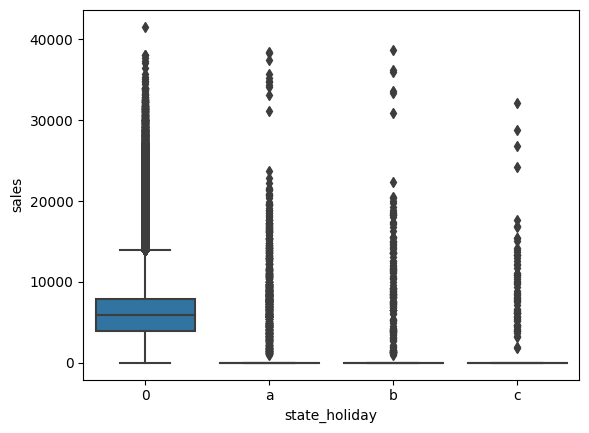

In [21]:
sns.boxplot(x= 'state_holiday', y = 'sales', data= df1) 
#dimensao das variaveis esta muito diferente por isso esse problema (muitos dias em que as vendas sao 0, as lojas estao fechadas)

<Axes: xlabel='assortment', ylabel='sales'>

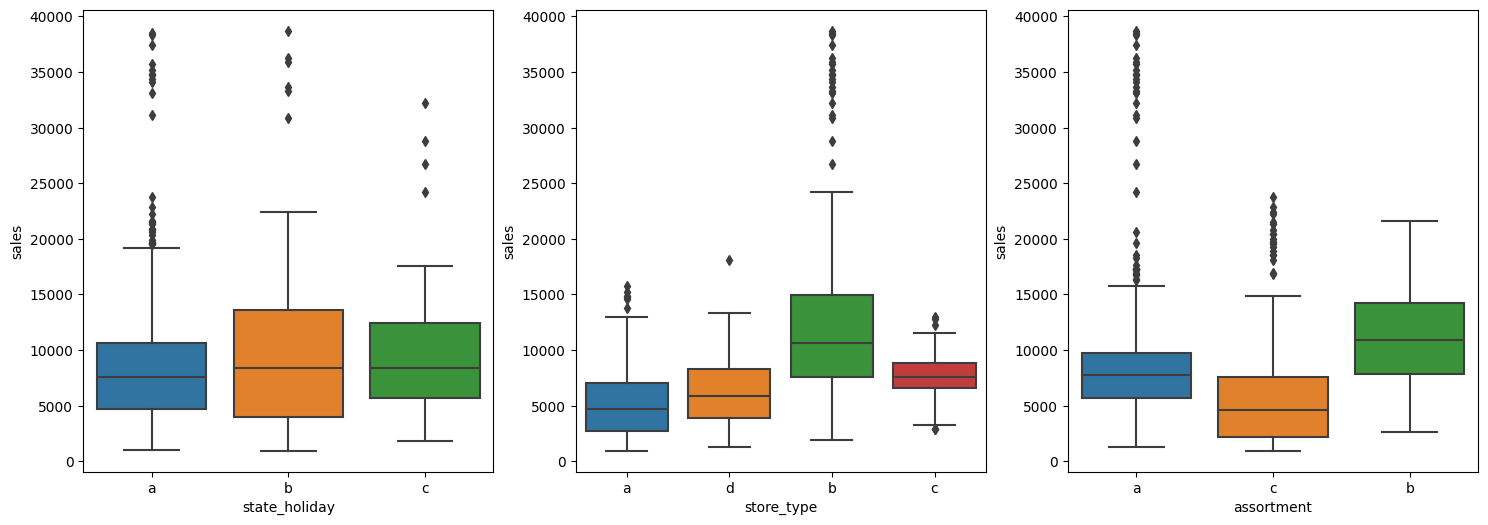

In [22]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(18, 6))

plt.subplot(131)
sns.boxplot( x = 'state_holiday', y = 'sales', data= aux1)

plt.subplot(1,3,2)
sns.boxplot( x = 'store_type', y = 'sales', data= aux1)

plt.subplot(1,3,3)
sns.boxplot( x = 'assortment', y = 'sales', data= aux1)


# 2.0. FEATURE ENGINEERING

In [23]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

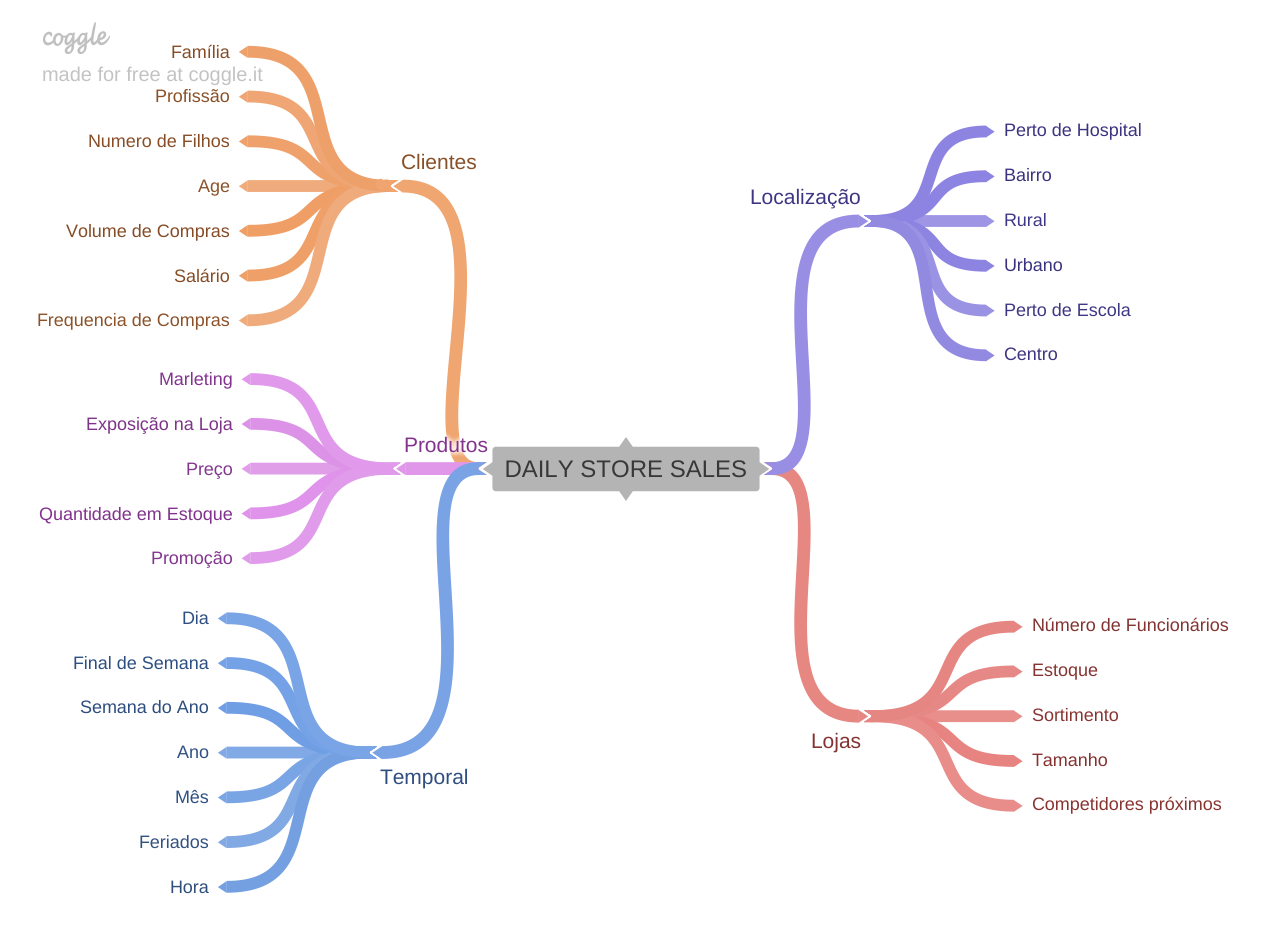

In [24]:
Image('C:/Users/rodri/Desktop/repos/data_science_em_producao/notebooks/img/MindMapHypothesis.png')

## 2.2. Criação das Hipóteses

### 2.2.1 Hipóteses Lojas

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores há mais tempo deveriam vender mais.

### 2.2.2 Hipóteses Produtos

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expoem mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas com promoção mais agressiva deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Temporal

**1.** Lojas abertas no feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**5.** Lojas deveriam vender menos nos finais de semana.

**6.** Lojas deveriam vender menos nos feriados estaduais.

## 2.3. Lista Final de Hipóteses

#analisar das hipoteses quais temos os dados necessarios

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores há mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas no feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11.** Lojas deveriam vender menos nos finais de semana.

**12.** Lojas deveriam vender menos nos feriados estaduais.

## 2.4. Feature Engineering

In [25]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7)) #não entendi pq subtraiu 7 dias
df2['promo_time_week'] = ((df2['date'] -df2['promo_since']) / 7).apply(lambda x: x.days).astype(int) #ao fazer a subtracao acima depois pode fazer datetime / int não entendi como

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


In [26]:
df2.sample(8).T

,712976,632305,681391,318923,61628,978007,556969,71213
store,162,886,912,321,304,938,255,969
day_of_week,1,4,2,6,6,2,1,5
date,2013-09-30 00:00:00,2013-12-12 00:00:00,2013-10-29 00:00:00,2014-10-04 00:00:00,2015-06-06 00:00:00,2013-02-05 00:00:00,2014-02-17 00:00:00,2015-05-29 00:00:00
sales,7106,5955,4926,6356,4776,9552,8529,4235
customers,507,592,623,711,805,902,781,672
open,1,1,1,1,1,1,1,1
promo,0,0,0,0,0,1,1,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0,0,0,0,1
store_type,d,a,c,c,a,a,c,a


# 3.0. FILTRAGEM DE VARIÁVEIS

In [27]:
df3 = df2.copy()

In [28]:
df3

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,public_holiday,1,a,...,1,2013,1,1,1,2013-00,2014-06-01,-18,2013-07-29,-30
1017205,1112,2,2013-01-01,0,0,0,0,public_holiday,1,c,...,0,2013,1,1,1,2013-00,2006-04-01,82,2012-12-31,0
1017206,1113,2,2013-01-01,0,0,0,0,public_holiday,1,a,...,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0
1017207,1114,2,2013-01-01,0,0,0,0,public_holiday,1,a,...,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


In [29]:
df3[['store', 'date']].groupby('store').count().reset_index()

,store,date
0,1,942
1,2,942
2,3,942
3,4,942
4,5,942
...,...,...
1110,1111,942
1111,1112,942
1112,1113,942
1113,1114,942


## 3.1 Filtragem das Linhas

In [30]:
# 'open' != 0 # quando a loja esta fechada nao temos informacoes
# 'sales' > 0

df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [31]:
# 'customers' #não tenho essa informaçao no momento da predição, teria que prever o valor dela
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis = 1)


In [32]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. ANÁLISE EXPLORATÓRIA DOS DADOS

In [33]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable

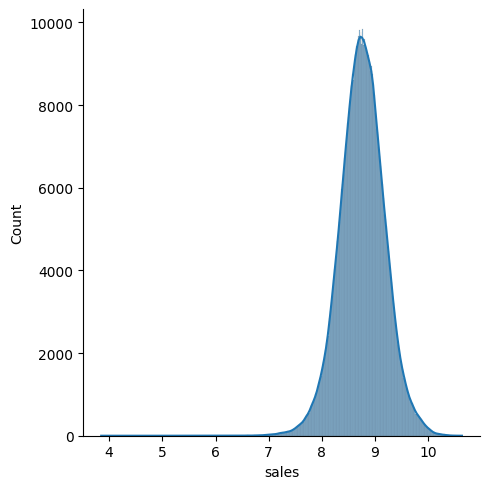

In [34]:
sns.displot(np.log1p(df4['sales']), kde = True ) # ,kde = False

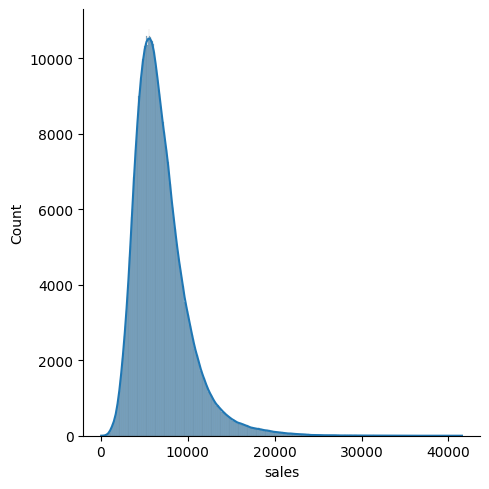

In [35]:
sns.displot(df4['sales'], kde = True )

<Axes: xlabel='sales', ylabel='Density'>

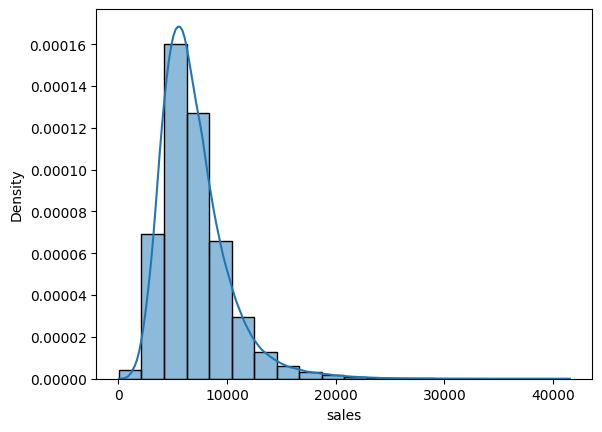

In [36]:
sns.histplot(df4['sales'], stat = 'density', bins = 20, kde = True ) # ,kde = False

### 4.1.2. Numerical Variable

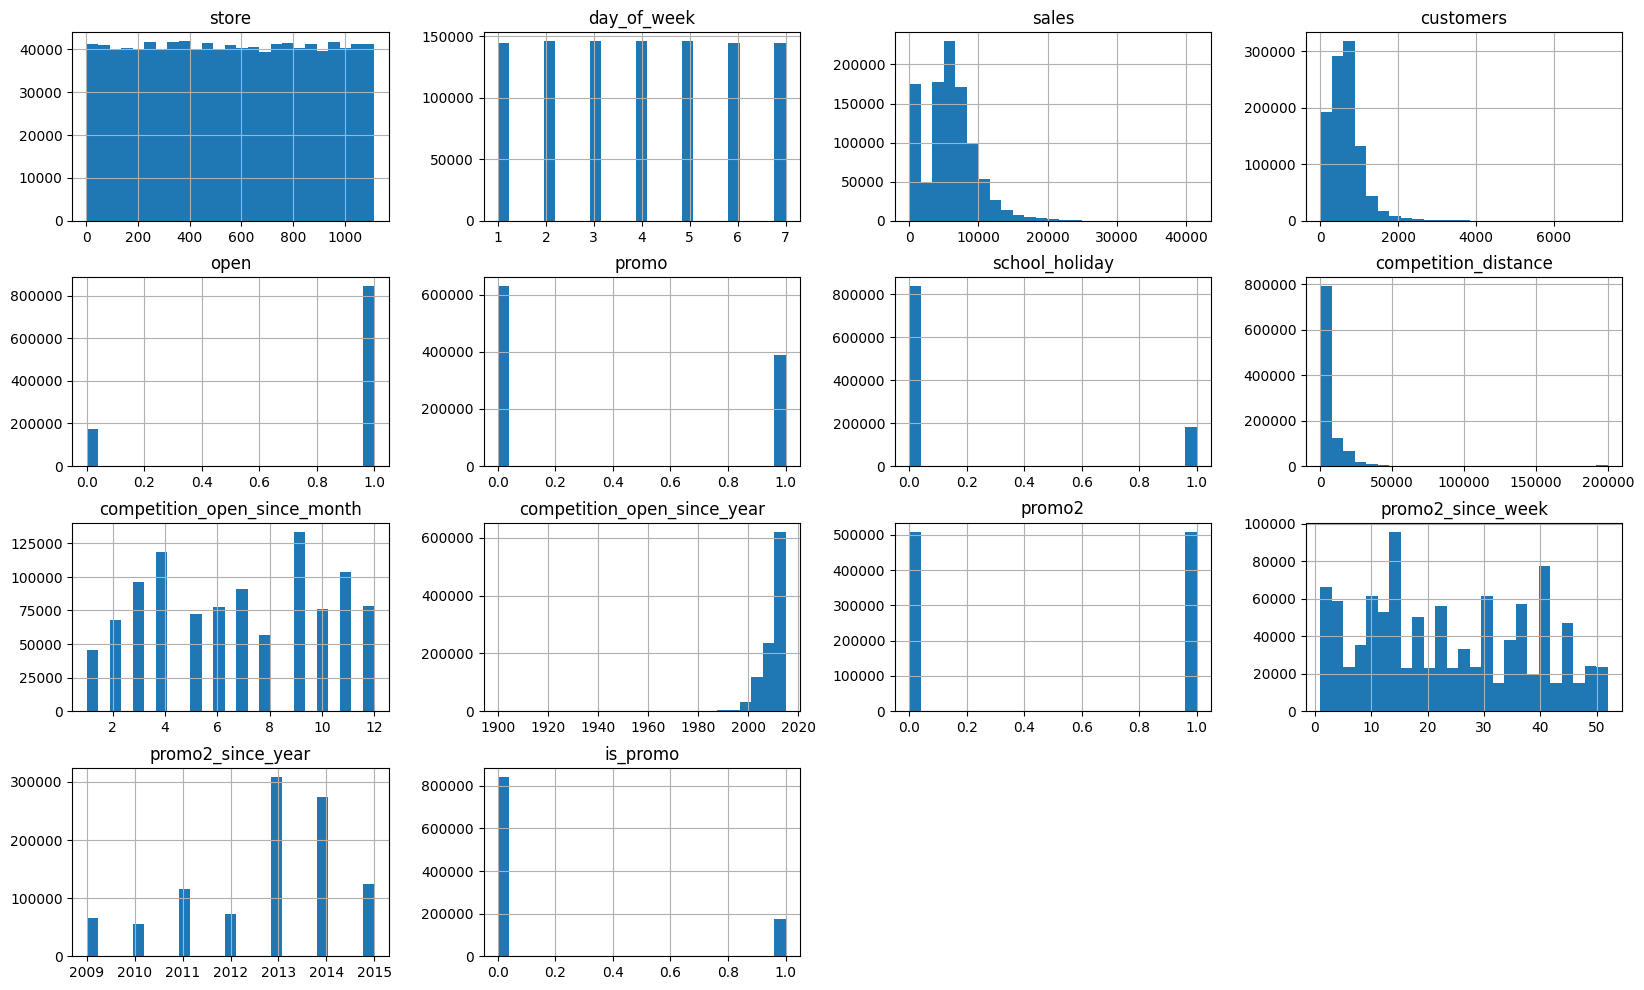

In [37]:

num_attributes.hist(bins = 25, figsize=(20,12));

### 4.1.3. Categorical Variable

In [38]:
cat_attributes.head()

,date,state_holiday,store_type,assortment,promo_interval,month_map
0,2015-07-31,0,c,a,0,Jul
1,2015-07-31,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,2015-07-31,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,2015-07-31,0,c,c,0,Jul
4,2015-07-31,0,a,a,0,Jul


In [39]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

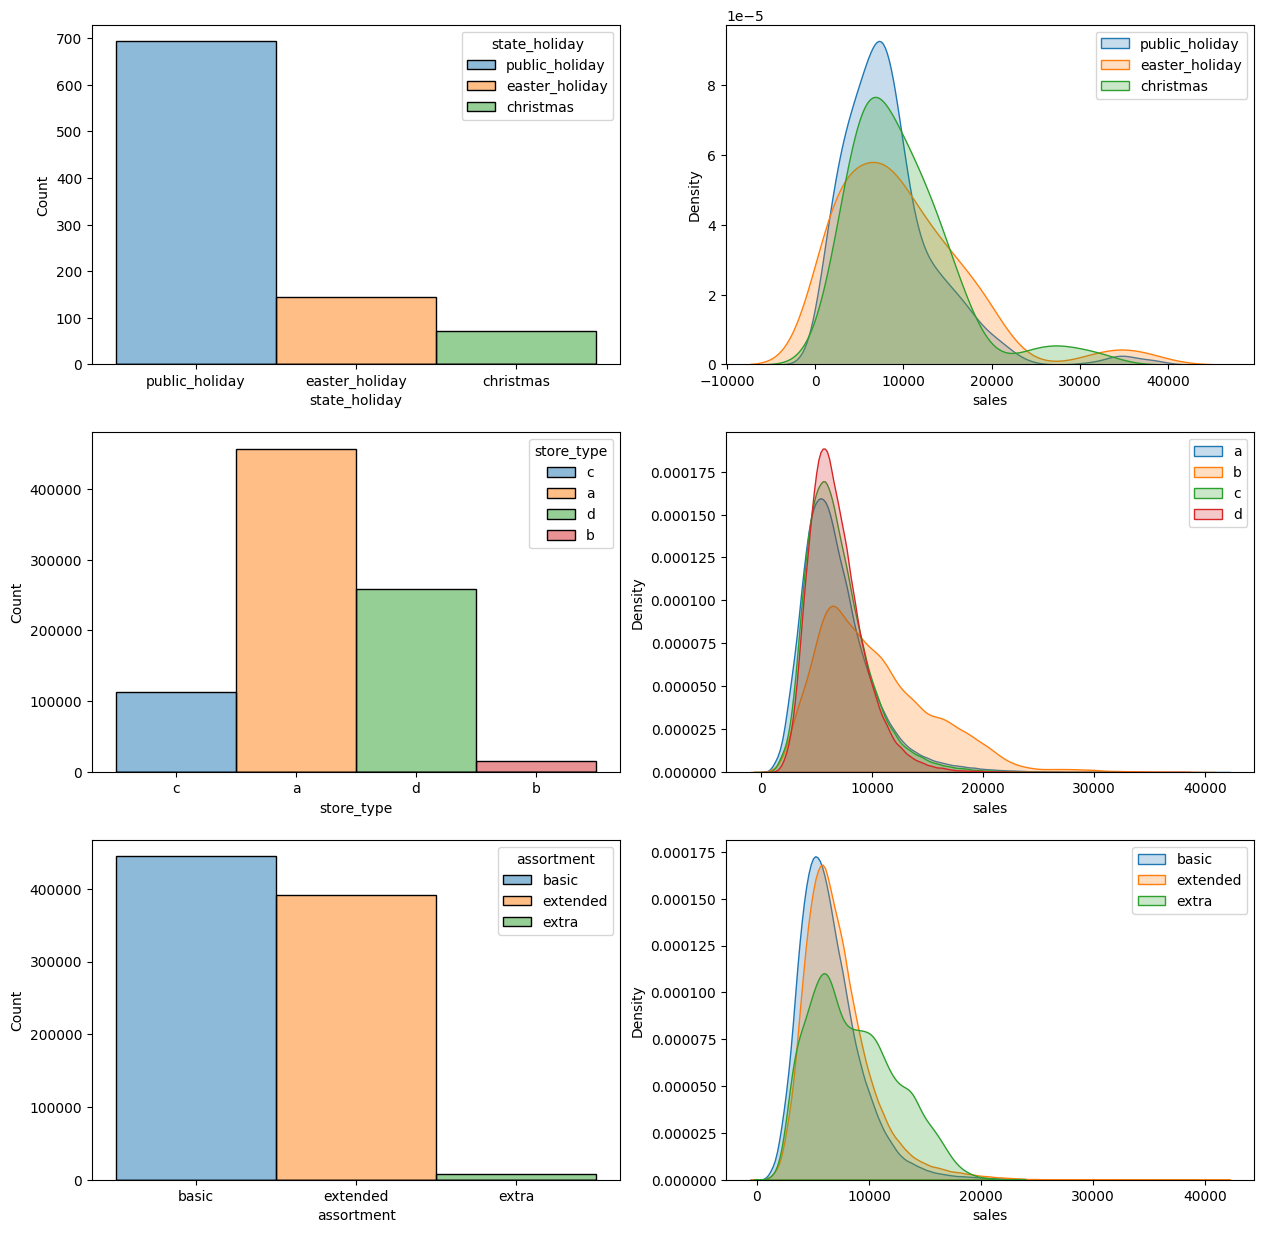

In [40]:
#state_holiday
a = df4[df4['state_holiday'] != 'regular_day']
b = pd.DataFrame(a['state_holiday'])

plt.figure(figsize=(15,15))

plt.subplot(3, 2, 1)
sns.histplot(b, x = 'state_holiday', hue = "state_holiday" )
plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', fill = True)
plt.legend();


#store_type

plt.subplot(3, 2, 3)
sns.histplot(df4, x = 'store_type', hue = "store_type" )
plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', fill = True)
plt.legend();

#assortment

plt.subplot(3, 2, 5)
sns.histplot(df4, x = 'assortment', hue = "assortment" )
plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', fill = True)
plt.legend();


## 4.2. Análise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.

Lojas com maior sortimento vendem mais no total, mas em média por loja não.

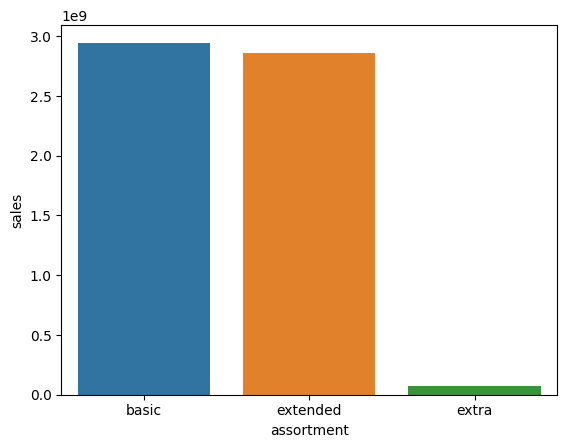

In [41]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

<Axes: xlabel='year_week'>

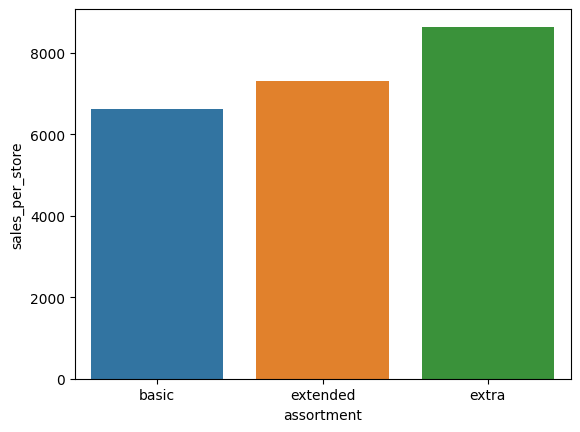

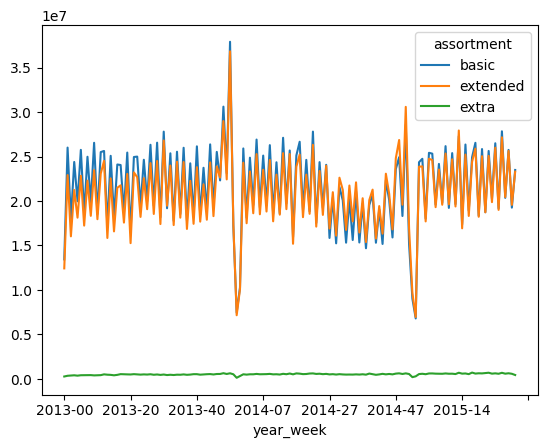

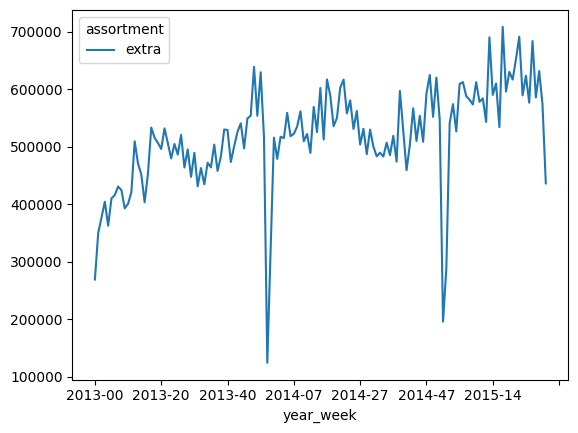

In [42]:
aux2 = df4[['assortment', 'store']].groupby('assortment').count().reset_index()
aux1 = aux1.merge(aux2, how = 'inner', on = 'assortment')
aux1['sales_per_store'] = aux1.apply(lambda x: (x['sales']/x['store']), axis = 1)
sns.barplot(x = 'assortment', y = 'sales_per_store', data = aux1);

aux3 = df4[['assortment', 'sales', 'year_week']].groupby(['year_week', 'assortment']).sum().reset_index()
aux3.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot()
#aux1.pivot

aux4 = aux3[aux3['assortment'] == 'extra']
aux4.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot()

### **H2.** Lojas com competidores mais próximos deveriam vender menos.

FALSA, lojas com competidores mais próximos vendem mais.


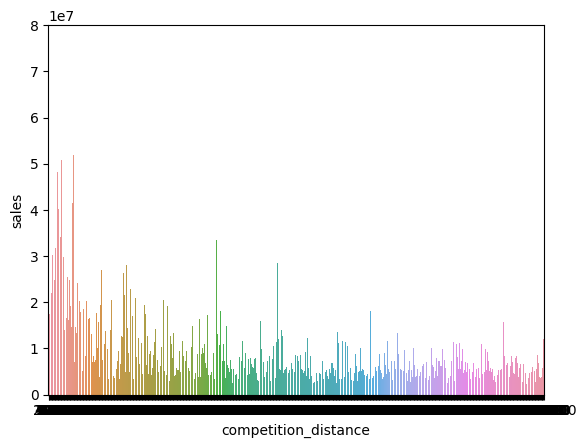

In [43]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.barplot(x = 'competition_distance', y = 'sales', data = aux1); #visulizacao ruim pq tem muitos valores de competition distance

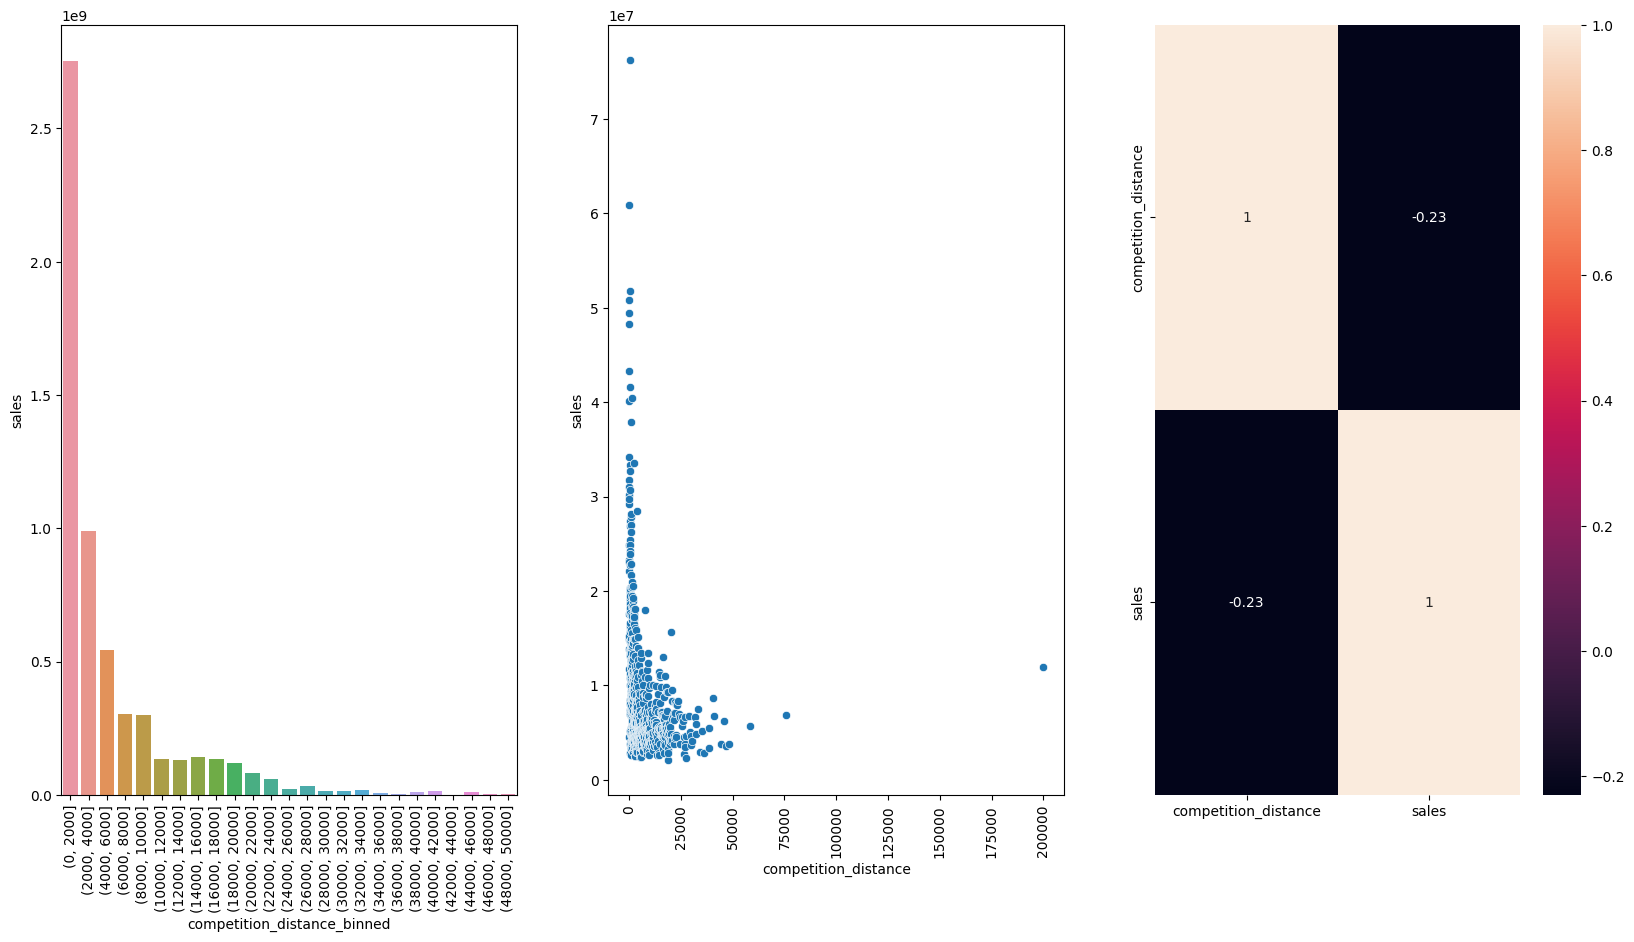

In [44]:
bins = list(np.arange(0, 51000, 2000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 90)

plt.subplot(1,3,2)
sns.scatterplot( x = 'competition_distance', y = 'sales', data = aux1)
plt.xticks(rotation = 90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson', numeric_only = True), annot = True); #vai de 1 a -1, a correlacao é de -0,23

### **H3.** Lojas com competidores há mais tempo deveriam vender mais.

FALSA, lojas com comopetidores à mais tempo vendem menos.

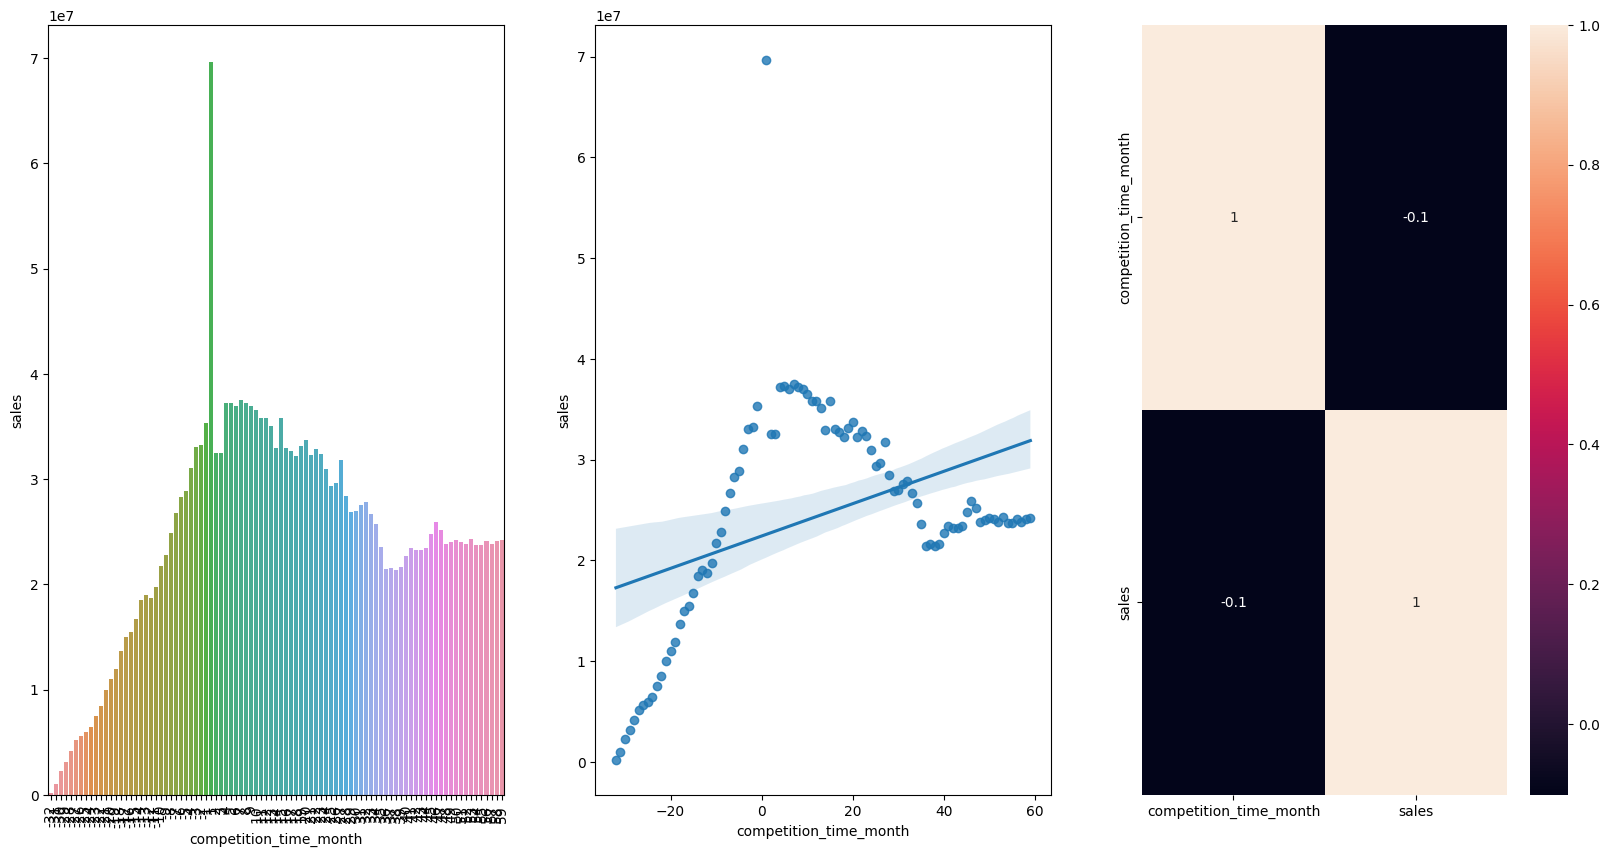

In [45]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 60) & (aux1['competition_time_month'] != 0)] #retiramos o 0 para visualizar melhor a tendencia

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2)
plt.xticks(rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2) #não é certo usar regplot (usar em comportmentos lineares)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson', numeric_only = True), annot = True); #vai de 1 a -1, a correlacao é de -0,1

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

FALSA, Lojas com promocao ativa por mais tempo vendem menos, depois de um certo periodo de promocao.

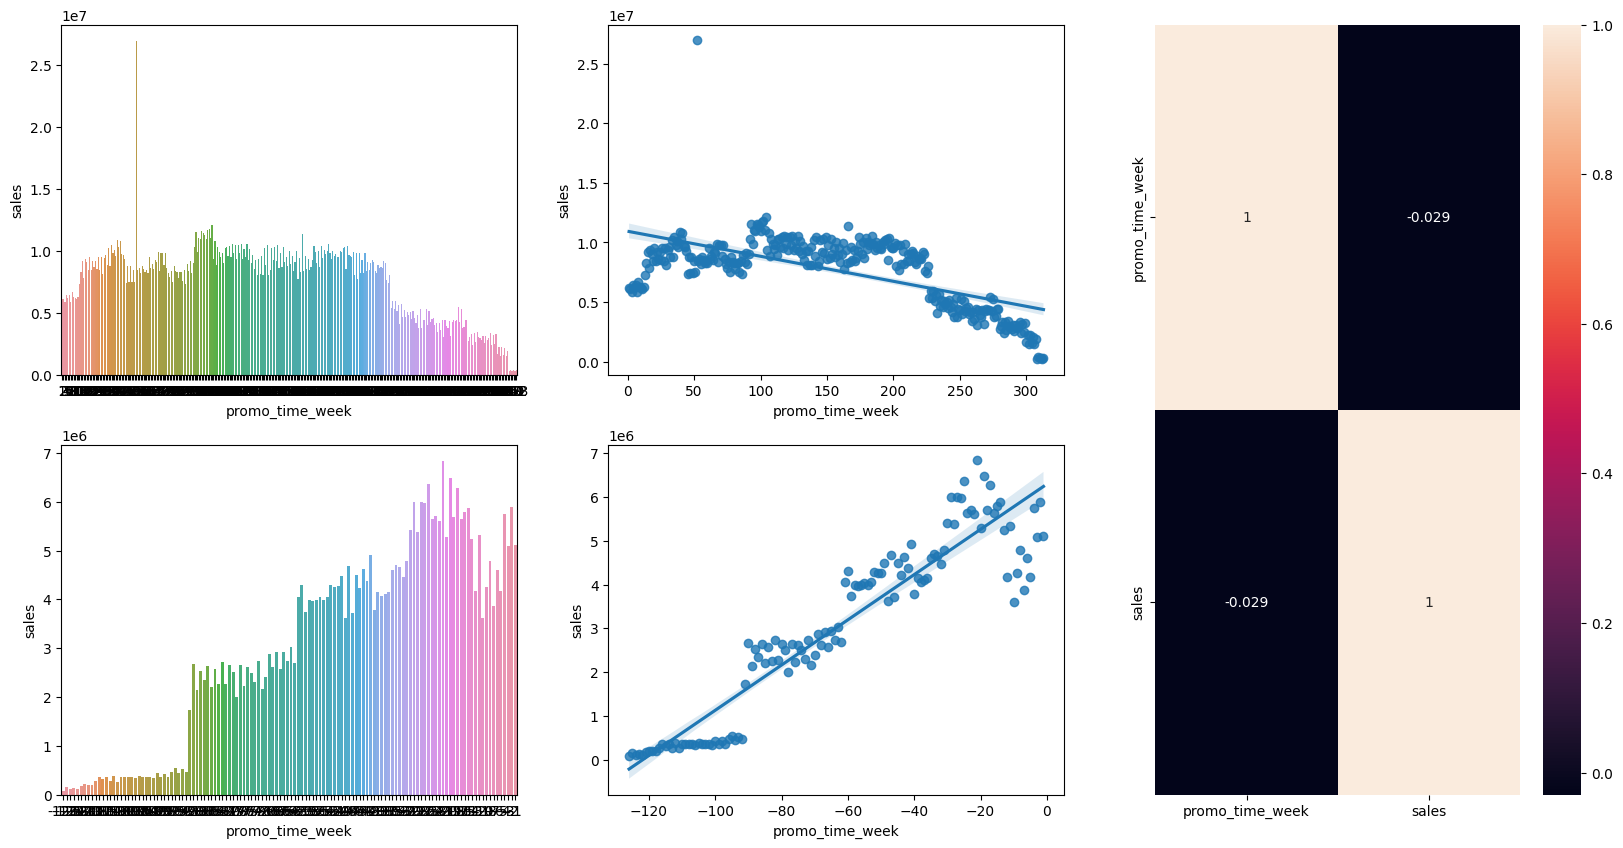

In [46]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.figure(figsize=(20,10))
grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promoção apos a data
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux2)

plt.subplot(grid[0,1])
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promoção apos a data
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux3)

plt.subplot(grid[1,1])
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method = 'pearson', numeric_only = True), annot = True); 
#tem uma baixa correlacao de -0.029, mas ela combinada com outras variáveis pode ter uma influencia maior



### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.

FALSA, lojas com mais praomoções consecutivas vendem menos

In [47]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


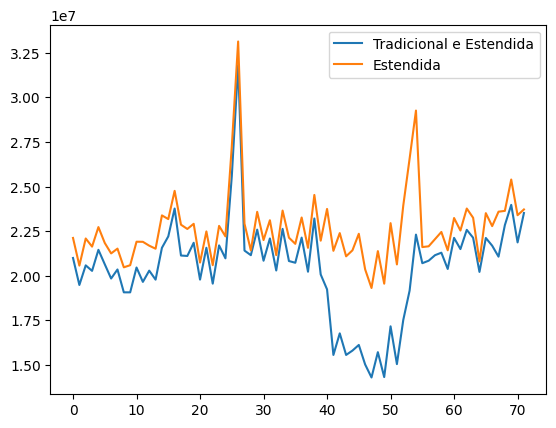

In [67]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index() 
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index() 
aux2.plot(ax = ax)

ax.legend( labels = ['Tradicional e Estendida', 'Estendida']);

### **H7.** Lojas abertas no feriado de Natal deveriam vender mais.

FALSA, lojas abertas no feriado de Natal não vendem mais.

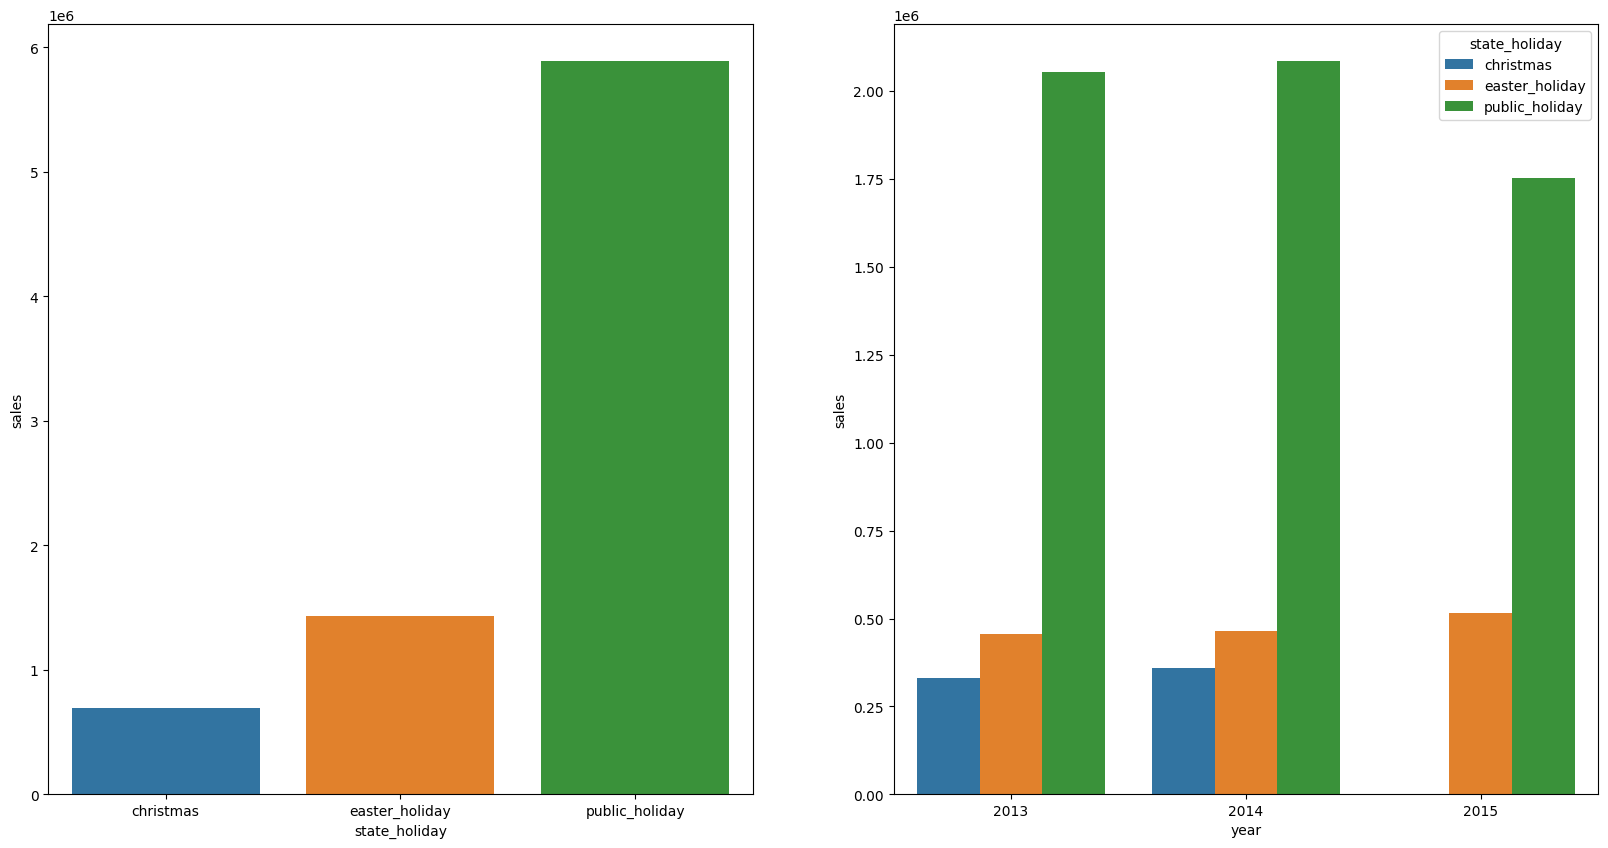

In [81]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y ='sales', data = aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y ='sales', hue = 'state_holiday', data = aux2);



### **H8.** Lojas deveriam vender mais ao longo dos anos.

FALSA, as lojas vendem ao longo dos anos

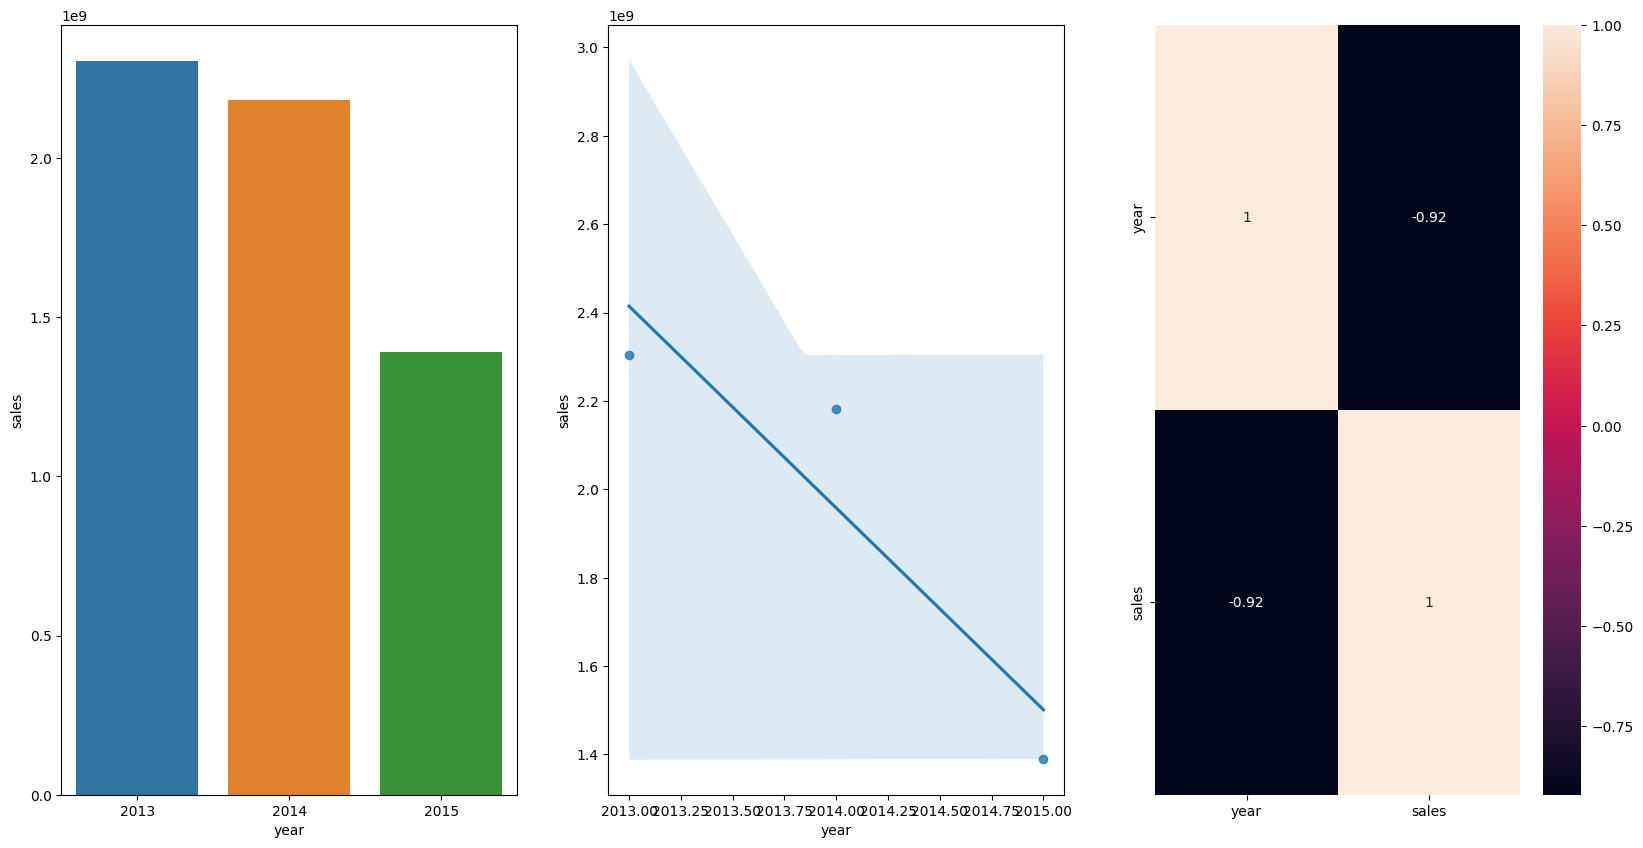

In [89]:
aux1 = df4[['sales', 'year']].groupby('year').sum().reset_index()

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
sns.barplot( x = 'year', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot( x = 'year', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson', numeric_only = True), annot = True);

### **H9.** Lojas deveriam vender mais no segundo semestre.

VERDADEIRO, as lojas vendem mia no segundo semestre.

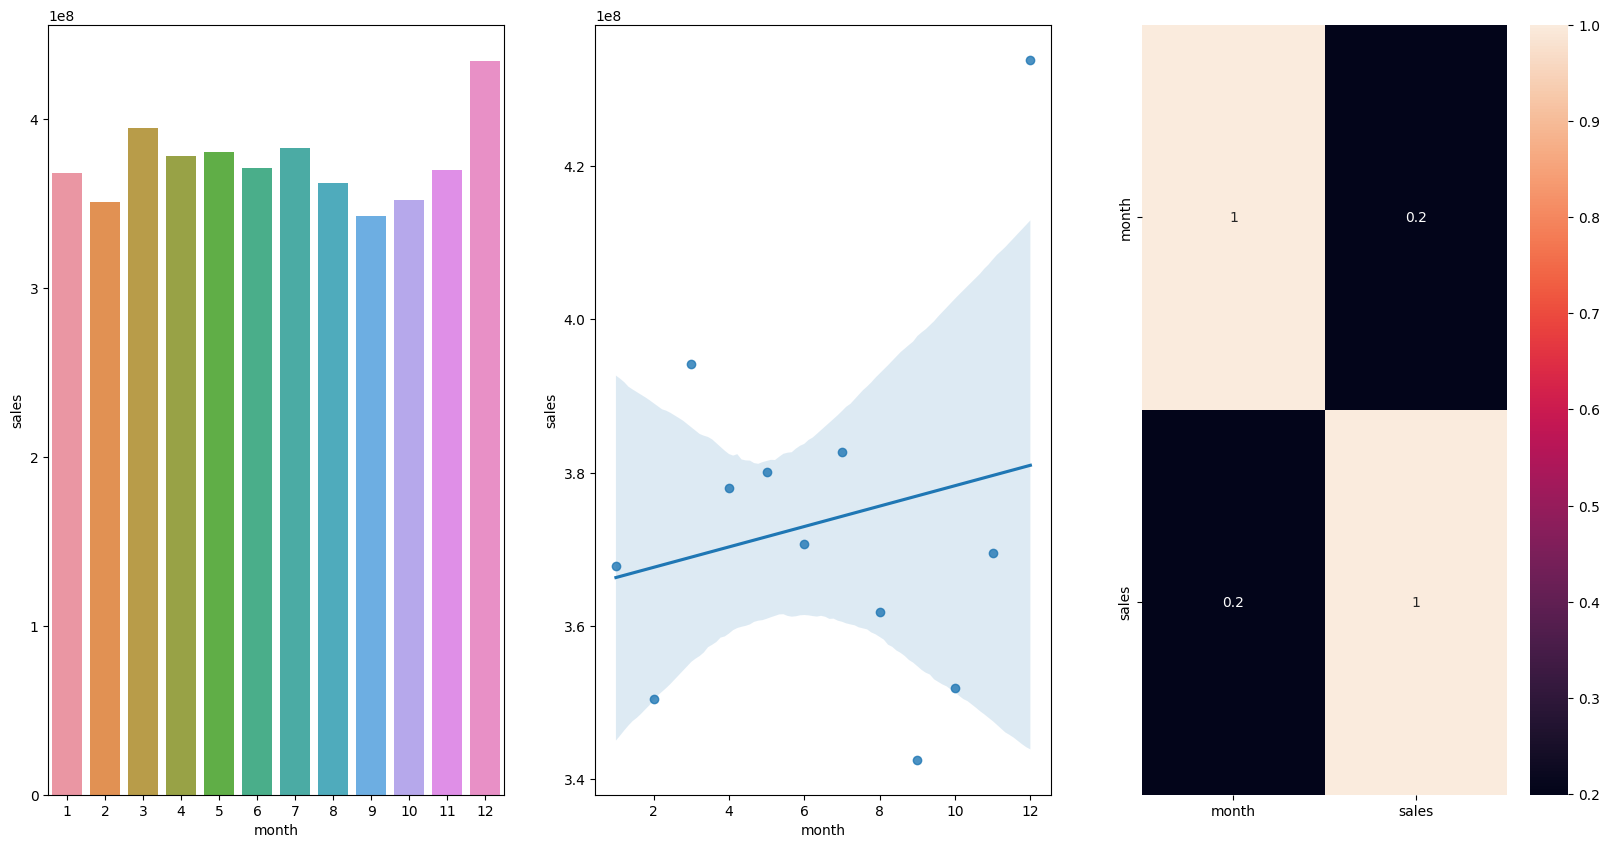

In [107]:
aux = df4[(df4['year'] == 2013) | (df4['year'] == 2014)] #tirei o ano de 2015 que nõa esta com os dados completos ate deezembro.
aux1 = aux[['sales', 'month']].groupby('month').sum().reset_index()

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
sns.barplot( x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot( x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson', numeric_only = True), annot = True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mes.

VERDADEIRA, as lojas vendem mais depois do dia 10 de cada mes.

In [97]:
aux1 = df4[['sales', 'day']].groupby('day').sum().reset_index()
aux1['before_after'] = aux1['day'].apply(lambda x: 'before 10 days' if (x <= 10) else 'after 10 days')

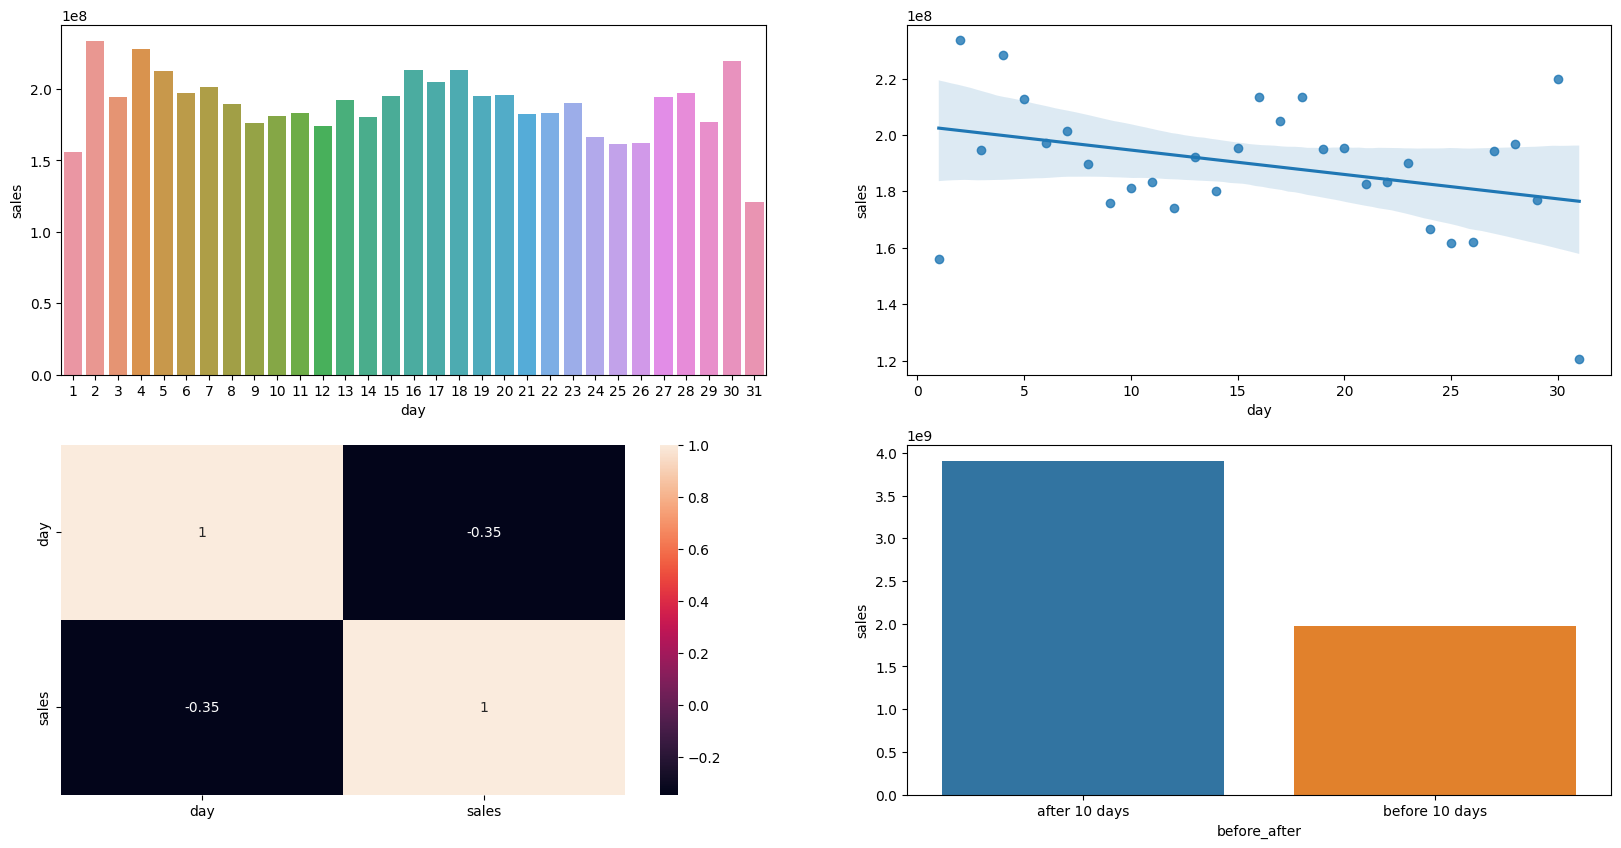

In [100]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sns.barplot( x = 'day', y = 'sales', data = aux1);

plt.subplot(2,2,2)
sns.regplot( x = 'day', y = 'sales', data = aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson', numeric_only = True), annot = True);

plt.subplot(2,2,4)
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot( x = 'before_after', y = 'sales', data = aux2);

### **H11.** Lojas deveriam vender menos nos finais de semana.

VERDADEIRA, lojas vendem menos nos finais de semana.

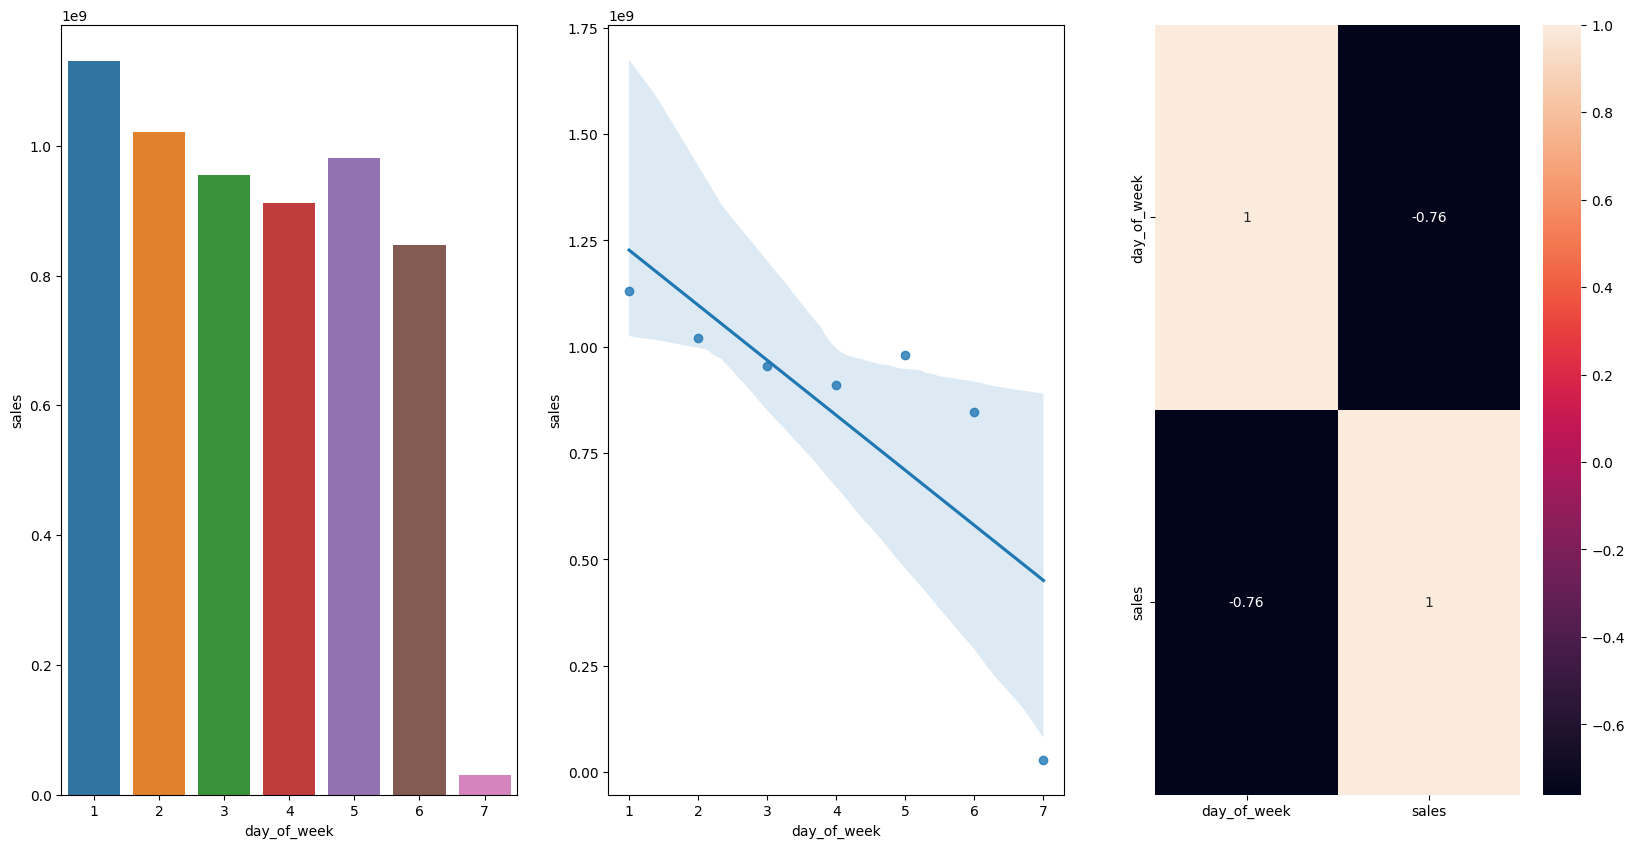

In [101]:
aux1 = df4[['sales', 'day_of_week']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
sns.barplot( x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot( x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson', numeric_only = True), annot = True);

### **H12.** Lojas deveriam vender menos nos feriados estaduais.

VERDADEIRA, as lojas vendem menos nos feriados escolares, exceto no mes de Agosto.

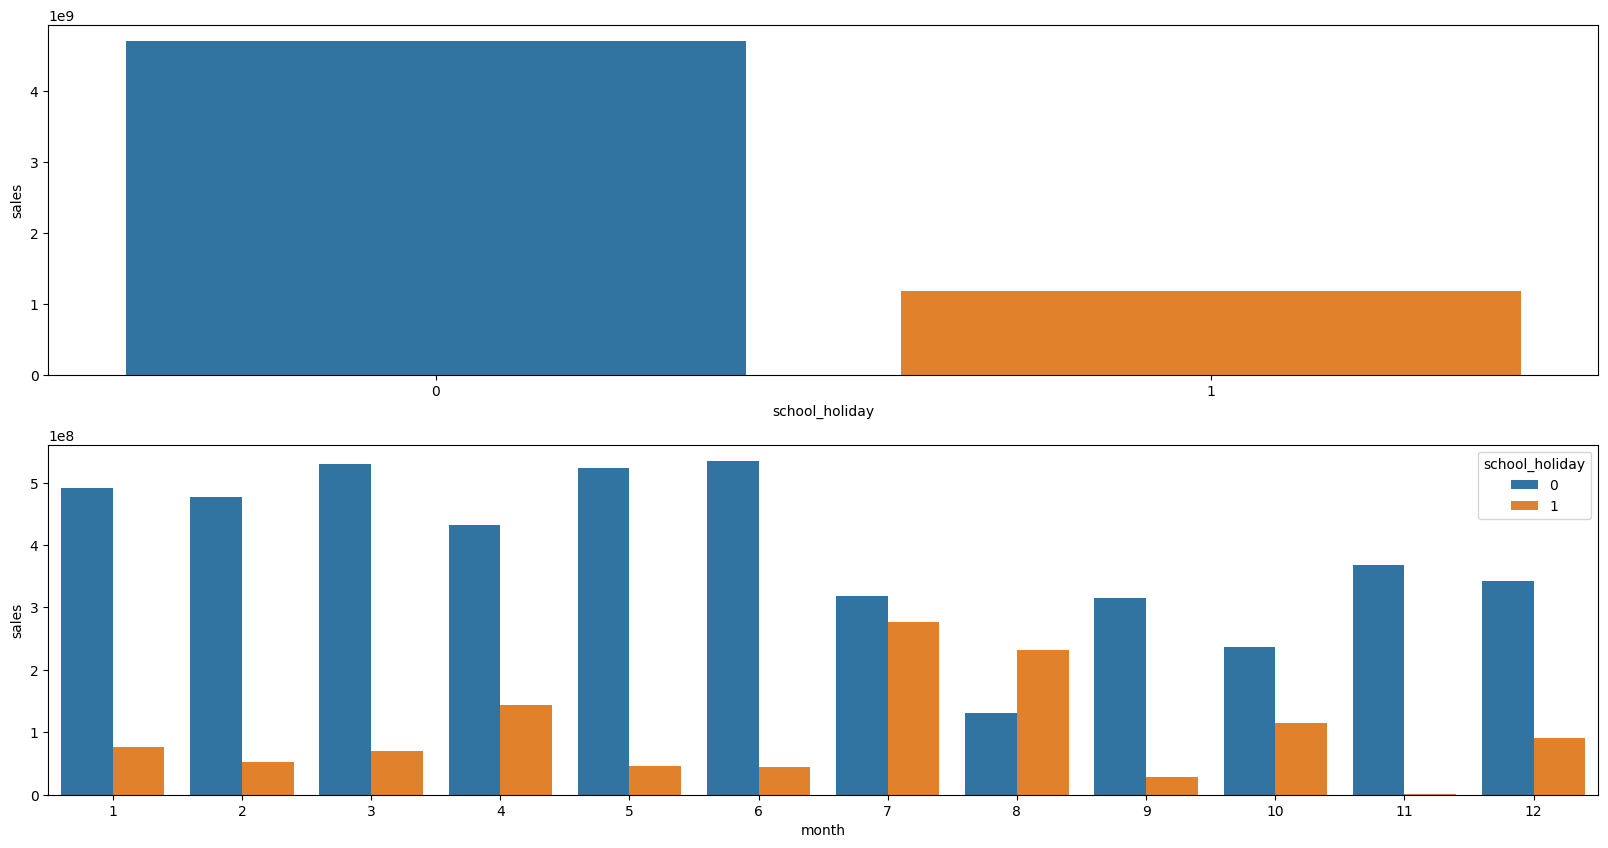

In [106]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y = 'sales', data = aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y = 'sales', hue = 'school_holiday', data = aux2);


In [112]:
from tabulate import tabulate

In [111]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Baixa'],
       ['H3', 'Falsa', 'Baixa'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', 'Falsa', 'Baixa']
      ]
print(tabulate(tab, headers = 'firstrow'))
       

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Baixa
H3           Falsa        Baixa
H4           Falsa        Baixa
H5           Falsa        Baixa


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

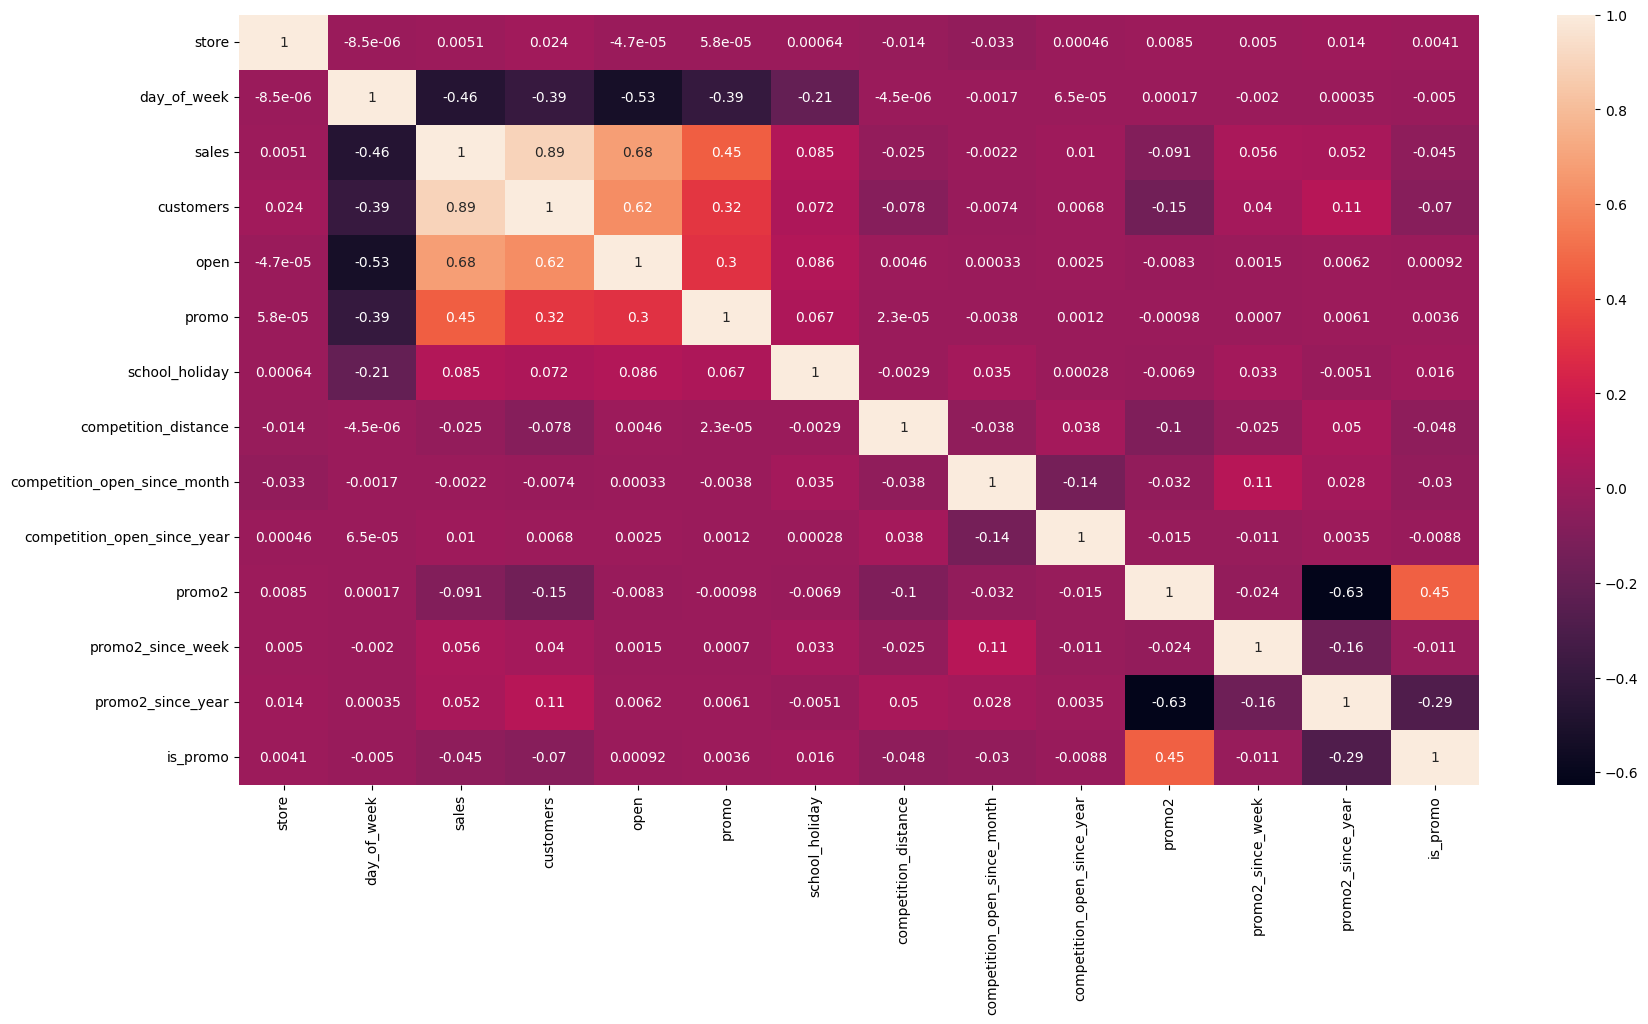

In [115]:
correlation = num_attributes.corr(method = 'pearson')

plt.figure(figsize=(20,10))
sns.heatmap(correlation, annot = True);

### 4.3.2 Categorical Attributes

In [171]:
#only categorical data
a = df4.select_dtypes(include = 'object')

#calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'])
a2 = cramer_v( a['state_holiday'], a['store_type'])
a3 = cramer_v( a['state_holiday'], a['assortment'])

a4 = cramer_v( a['store_type'], a['state_holiday'])
a5 = cramer_v( a['store_type'], a['store_type'])
a6 = cramer_v( a['store_type'], a['assortment'])

a7 = cramer_v( a['assortment'], a['state_holiday'])
a8 = cramer_v( a['assortment'], a['store_type'])
a9 = cramer_v( a['assortment'], a['assortment'])

#final Dataser
d = pd.DataFrame( {'state_holiday': [a1,a2,a3],
                   'store_type': [a4,a5,a6],
                   'assortment': [a7,a8,a9] })

d = d.set_index(d.columns)
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


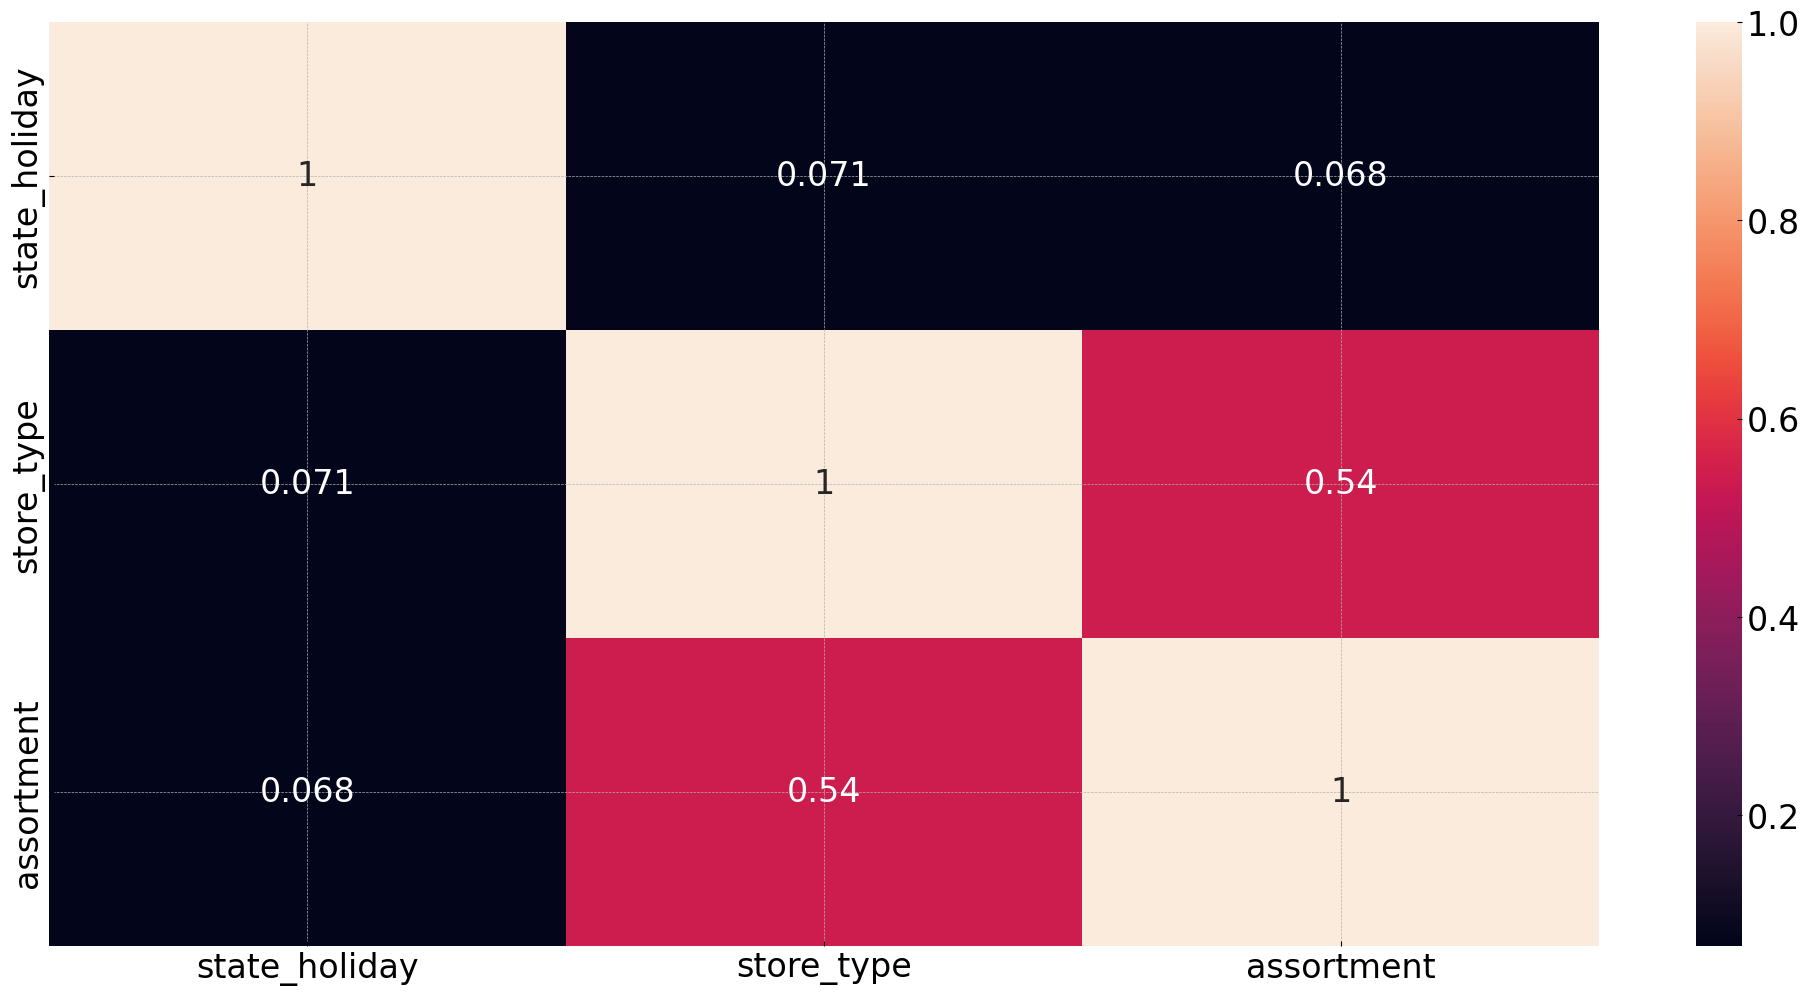

In [166]:
sns.heatmap(d, annot = True);

In [178]:
#Outra forma de fazer
from pycorrcat.pycorrcat import plot_corr, corr_matrix

In [176]:
correlation_matrix = corr_matrix(a, ['state_holiday', 'store_type', 'assortment'])
correlation_matrix

,state_holiday,store_type,assortment
state_holiday,1.000000,0.071040,0.067519
store_type,0.071040,1.000000,0.538454
assortment,0.067519,0.538454,1.000000


<Axes: >

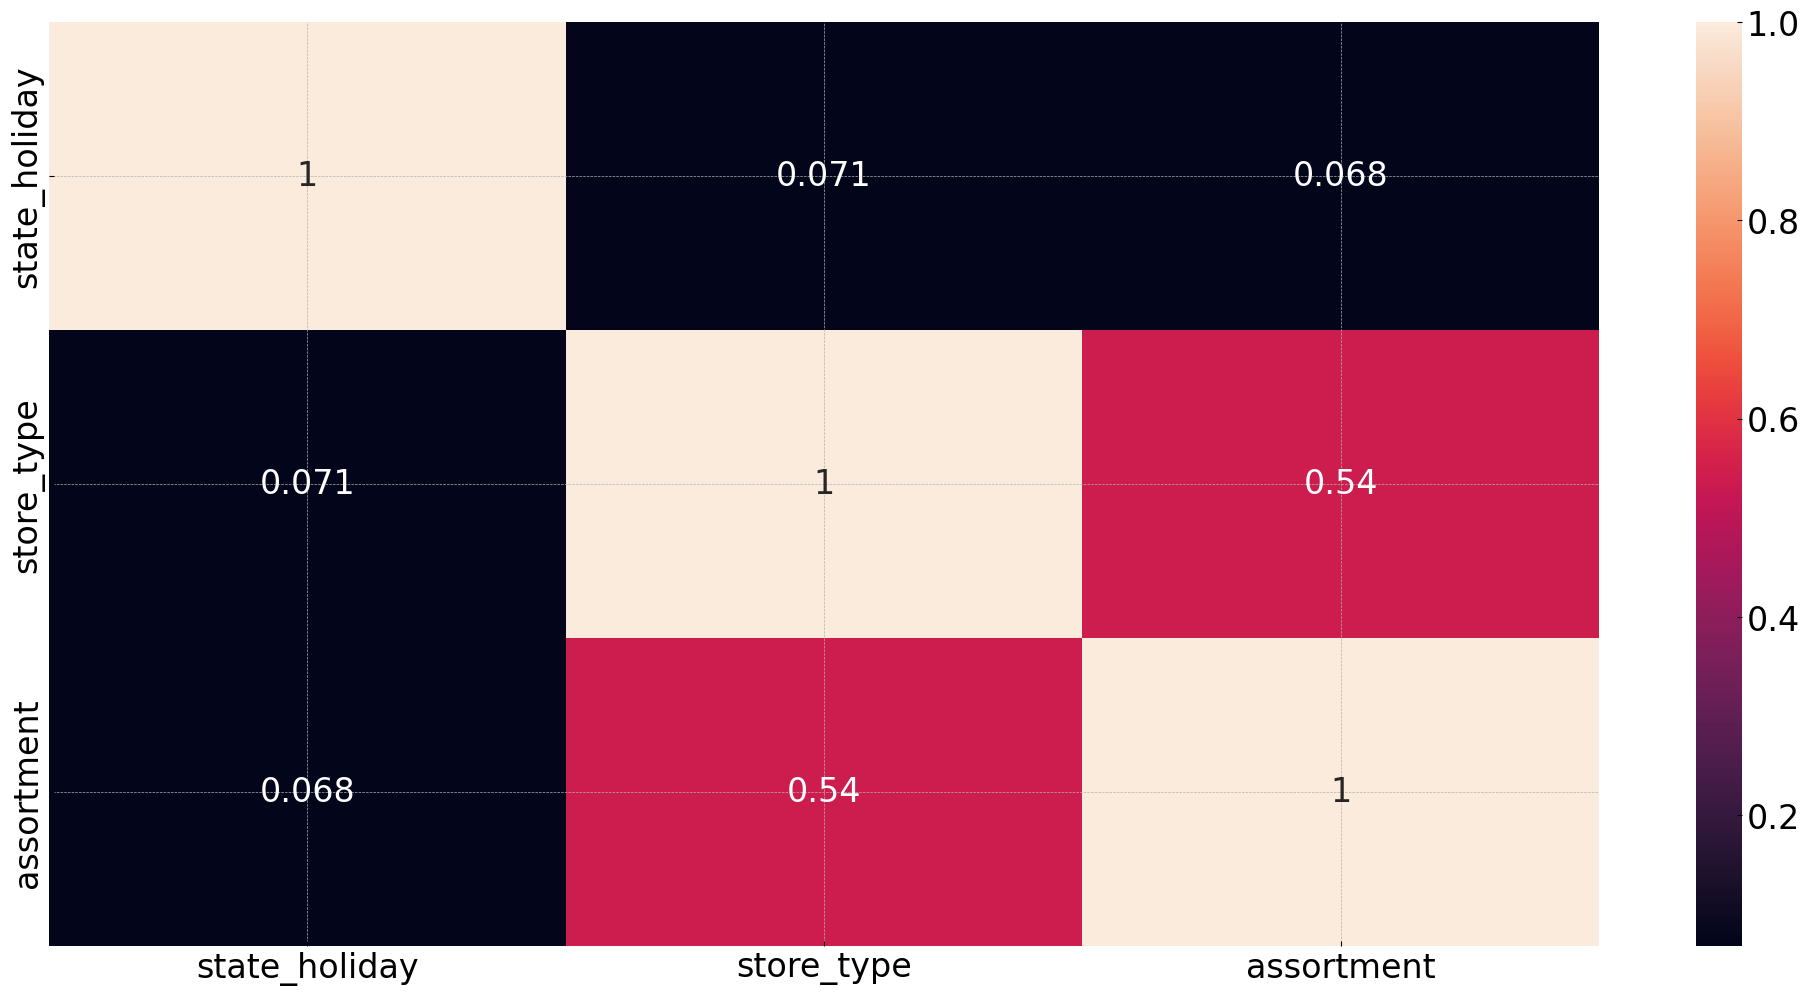

In [177]:
plot_corr(a, ['state_holiday', 'store_type', 'assortment']);

# 5.0. DATA PREPARATION

## 5.1. Normalização

## 5.2. Rescaling

## 5.3. Transformação